# HW7: QMC and Credit Derivatives

## Preliminaries

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
import scipy.integrate as integrate
import statsmodels.api as sm

### Random Seed

In [2]:
seed=68307
gen=np.random.default_rng()

### Code

#### Gaussian Copula

In [3]:
class GaussianCopula:
    def __init__(self,rho):
        self.rho=rho
    def generate(self,N,gen):
        D=len(self.rho)
        Z=stats.multivariate_normal(np.zeros(D),self.rho,seed=gen,allow_singular=True).rvs(size=N)
        U=stats.norm.cdf(Z)
        return U

#### Generate Distribution from Copula 

In [4]:
def generate_distribution(dists,copula,N,gen):
    U=copula.generate(N,gen) # correlated U(0,1)
    Ss=[]
    for i1,dist in enumerate(dists):
        S=dist.ppf(U[:,i1]) # inverse cdf
        Ss.append(S)
    return np.stack(Ss,axis=-1)

## Problem 1: QMC and Low discrepancy Sequences

### Problem 1.1:

Define the function
$$
    f_1(u_1,u_2) = \exp\left\{-\left(u_1-\frac{1}{2}\right)^2-\left(u_2-\frac{1}{2}\right)^2\right\}
$$

In [5]:
def func1(u1,u2):
    pass

In [6]:
def func1(u1,u2):
    x1=(u1-0.5)
    x2=(u2-0.5)
    r2=(x1**2+x2**2)
    return np.exp(-r2)


### Problem 1.2

Using function [matplotlib.pyplot.contourf](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contourf.html) make a **contour plot**
of the function on the square $[0,1]\times[0,1]$:

In [7]:
u1=np.linspace(0,1,201)
u2=np.linspace(0,1,201)
F1=func1(u1[:,np.newaxis],u2[np.newaxis,:])
F1.shape

(201, 201)

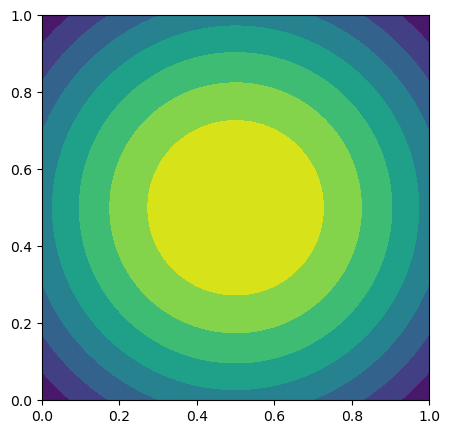

In [8]:
plt.figure(figsize=(5,5))
plt.contourf(u1,u2,F1)

### Problem 1.3

Using function [scipy.integrate.dblquad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.dblquad.html) find the integral of the function $f_1$
in the square region $[0,1]\times[0,1]$ 
$$
    I = \int_0^1 \int_0^1 \text{d}u_1 \text{d}u_2\, f_1(u_1,u_2)
$$

In [9]:
I0,tol=integrate.dblquad(func1,0,1,0,1,)
I0,tol

(0.8511206675087946, 1.0242495882834934e-14)

### Problem 1.4

For $N=2^m$ with $m=3,\dots,21$ compute:
1. The integral $I$ defined in Problem 1.3 using QMC with the Sobol Sequence.
$$
    \hat{I}^{\text{sobol}}_m = \frac{1}{N} \sum_{i=1}^{N} f_1(u_{i,1},u_{i,2})
$$
  where $u_i$ is a Sobol sequence.
2. The same integral using Monte Carlo:
$$
    \hat{I}^{\text{random}}_m = \frac{1}{N} \sum_{i=1}^{N} f_1(u_{i,1},u_{i,2})
$$
  where $u_i$ is  random, uniformly distributed sequence.

Store the results in two arrays for later use.

[HINT] Set the argument `seed` of [scipy.stats.qmc](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.qmc.Sobol.html) to this notebook `seed` value (set in the preliminaries) so that your get reproducible results.

In [10]:
D=2
ms=np.arange(3,22)
I_qmc=np.empty(len(ms))
I_rnd=np.empty(len(ms))
for idx,m in enumerate(ms):
    sampler=stats.qmc.Sobol(d=D,seed=seed)
    U=sampler.random(n=2**m)
    val=func1(U[:,0],U[:,1])
    I_qmc[idx]=val.mean()
    Ur=gen.uniform(size=(2**m,D))
    val=func1(Ur[:,0],Ur[:,1])
    I_rnd[idx]=val.mean()

    

### Problem 1.5

Compute the integration errors
\begin{align*}
     \epsilon^{\text{sobol}}_m&=\left|\hat{I}^{\text{sobol}}_m -I \right| \\
     \epsilon^{\text{random}}_m&=\left|\hat{I}^{\text{random}}_m -I \right|
\end{align*}
for $m=3,\dots,21$ (21 included)

Make a scatter plot of $\log \epsilon^{\text{sobol}}_m$ and $\log \epsilon^{\text{random}}_m$ vs $m$

In [11]:
error_qmc=np.abs(I_qmc-I0)
error_rnd=np.abs(I_rnd-I0)

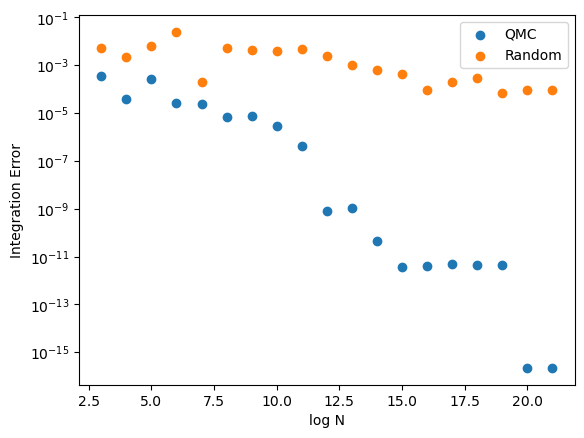

In [12]:
plt.scatter(ms,error_qmc,label="QMC")
plt.scatter(ms,error_rnd,label="Random")
plt.yscale("log")
plt.xlabel("log N")
plt.ylabel("Integration Error")
plt.legend()

### Problem 1.6

Using [statsmodels.regression.linear_model.OLS](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.html)
Estimate the parameters $\alpha$ and $\beta$ of a linear regression
$$
    \log \epsilon_m  = \alpha+\beta m
$$
do this for both the sobol and  random sequence.

Which rate of convergence is faster, Sobol or Random sequence?

[HINT] To fit the constant term `a` you can use [sm.add_constant](https://www.statsmodels.org/dev/generated/statsmodels.tools.tools.add_constant.html) to add a row of ones to the array of indexes $m$

In [13]:
model=sm.OLS(np.log(error_qmc),sm.add_constant(ms))
res=model.fit()
a_qmc,b_qmc=res.params
res.summary()

/usr/local/share/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                     211.5
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           5.06e-11
Time:                        07:33:48   Log-Likelihood:                -43.693
No. Observations:                  19   AIC:                             91.39
Df Residuals:                      17   BIC:                             93.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6637      1.409     -0.471      0.644      -3.637       2.309
x1            -1.5535      0.107    -14.541      0.000      -1.779      -1.328
==============================================================================
Omnibus:                        1.746   Durbin-Watson:                   1.176
Prob(Omnibus):                  0.418   Jarque-Bera (JB):                0.955
Skew:                           0.039   Prob(JB):                        0.620
Kurtosis:                       1.904   Cond. No.                         31.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
model=sm.OLS(np.log(error_rnd),sm.add_constant(ms))
res=model.fit()
a_rnd,b_rnd=res.params
res.summary()

/usr/local/share/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.650
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     31.61
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           3.05e-05
Time:                        07:33:48   Log-Likelihood:                -27.742
No. Observations:                  19   AIC:                             59.48
Df Residuals:                      17   BIC:                             61.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8414      0.609     -6.311      0.000      -5.125      -2.557
x1            -0.2594      0.046     -5.622      0.000      -0.357      -0.162
==============================================================================
Omnibus:                        5.713   Durbin-Watson:                   2.143
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                3.235
Skew:                          -0.876   Prob(JB):                        0.198
Kurtosis:                       4.009   Cond. No.                         31.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Problem 1.7

Repeat the Scatter plot of Problem 1.5, but now add trend lines $\alpha+\beta m$ to the log errors of the Sobol and random sequences.

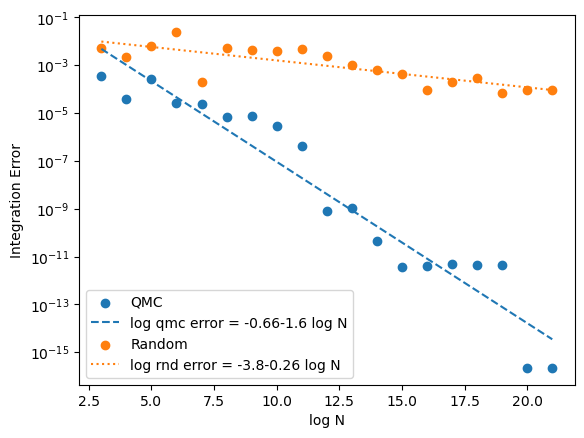

In [15]:
plt.scatter(ms,error_qmc,label="QMC")
plt.plot(ms,np.exp(a_qmc+b_qmc*ms),linestyle="dashed",label=rf"log qmc error = {a_qmc:0.2}{b_qmc:0.2} log N")
plt.scatter(ms,error_rnd,label="Random")
plt.plot(ms,np.exp(a_rnd+b_rnd*ms),linestyle="dotted",label=rf"log rnd error = {a_rnd:0.2}{b_rnd:0.2} log N")
plt.yscale("log")
plt.xlabel("log N")
plt.ylabel("Integration Error")
plt.legend()

## Problem 2: QMC with a harder integrant

Repeat all steps for Problem 1 ( Problem 1.1 to Problem 1.7) but now with function:

$$
    f_2(u_1,u2)=\begin{cases}
 \exp \left(-r^2\right) \ \ \text{if } \ \ r^2 < \frac{1}{5} \\
 0 \ \ \text{otherwise}
        \end{cases}
$$
where
$$
    r^2 = \left(u_1-\frac{1}{2}\right)^2+\left(u_2-\frac{1}{2}\right)^2
$$

[HINT] You can ignore any warning from [scipy.integrate.dblquad](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.dblquad.html), they mean this function is harder to integrate.

In [16]:
def func2(u1,u2):
    x1=(u1-0.5)
    x2=(u2-0.5)
    r2=(x1**2+x2**2)
    return np.exp(-r2)*(r2<0.2)

In [17]:
F2=func2(u1[:,np.newaxis],u2[np.newaxis,:])

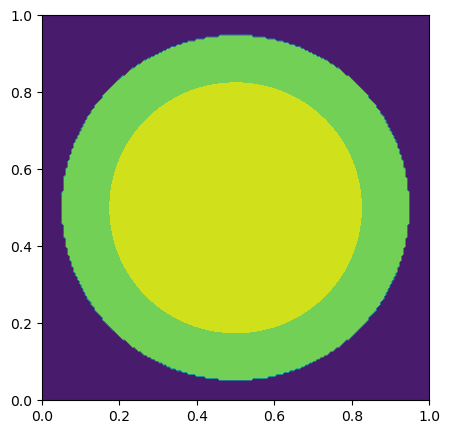

In [18]:
plt.figure(figsize=(5,5))
plt.contourf(u1,u2,F2)

In [19]:
I0,tol=integrate.dblquad(func2,0,1,0,1,)
I0,tol

/usr/local/share/anaconda3/lib/python3.9/site-packages/scipy/integrate/_quadpack_py.py:1151: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


(0.5694741423908667, 1.907127356735133e-06)

In [20]:
D=2
ms=np.arange(3,22)
I2_qmc=np.empty(len(ms))
I2_rnd=np.empty(len(ms))
for idx,m in enumerate(ms):
    sampler=stats.qmc.Sobol(d=D,seed=seed)
    U=sampler.random(n=2**m)
    val=func2(U[:,0],U[:,1])
    I2_qmc[idx]=val.mean()
    Ur=gen.uniform(size=(2**m,D))
    val=func2(Ur[:,0],Ur[:,1])
    I2_rnd[idx]=val.mean()

In [21]:
error2_qmc=np.abs(I2_qmc-I0)
error2_rnd=np.abs(I2_rnd-I0)

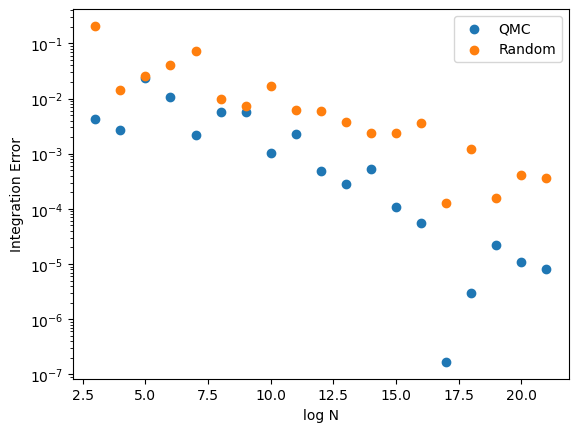

In [22]:
plt.scatter(ms,error2_qmc,label="QMC")
plt.scatter(ms,error2_rnd,label="Random")
plt.yscale("log")
plt.xlabel("log N")
plt.ylabel("Integration Error")
plt.legend()

In [23]:
model=sm.OLS(np.log(error2_qmc),sm.add_constant(ms))
res=model.fit()
a2_qmc,b2_qmc=res.params
res.summary()

/usr/local/share/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     50.80
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           1.69e-06
Time:                        07:33:59   Log-Likelihood:                -35.376
No. Observations:                  19   AIC:                             74.75
Df Residuals:                      17   BIC:                             76.64
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.1838      0.910     -2.401      0.028      -4.103      -0.265
x1            -0.4915      0.069     -7.127      0.000      -0.637      -0.346
==============================================================================
Omnibus:                       18.383   Durbin-Watson:                   1.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.252
Skew:                          -1.845   Prob(JB):                     6.60e-05
Kurtosis:                       6.272   Cond. No.                         31.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
model=sm.OLS(np.log(error2_rnd),sm.add_constant(ms))
res=model.fit()
a2_rnd,b2_rnd=res.params
res.summary()

/usr/local/share/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     81.45
Date:                Mon, 06 Mar 2023   Prob (F-statistic):           6.81e-08
Time:                        07:33:59   Log-Likelihood:                -23.071
No. Observations:                  19   AIC:                             50.14
Df Residuals:                      17   BIC:                             52.03
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4902      0.476     -3.131      0.006      -2.494      -0.486
x1            -0.3257      0.036     -9.025      0.000      -0.402      -0.250
==============================================================================
Omnibus:                        2.966   Durbin-Watson:                   2.700
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                1.881
Skew:                          -0.771   Prob(JB):                        0.390
Kurtosis:                       2.979   Cond. No.                         31.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

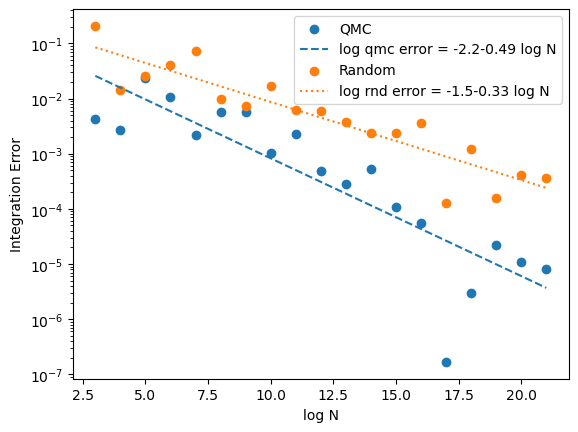

In [25]:
plt.scatter(ms,error2_qmc,label="QMC")
plt.plot(ms,np.exp(a2_qmc+b2_qmc*ms),linestyle="dashed",label=rf"log qmc error = {a2_qmc:0.2}{b2_qmc:0.2} log N")
plt.scatter(ms,error2_rnd,label="Random")
plt.plot(ms,np.exp(a2_rnd+b2_rnd*ms),linestyle="dotted",label=rf"log rnd error = {a2_rnd:0.2}{b2_rnd:0.2} log N")
plt.yscale("log")
plt.xlabel("log N")
plt.ylabel("Integration Error")
plt.legend()

In [26]:
# QMC is still better than Random, but the difference now is a lot smaller

## Problem 3: Value At Risk bond portfolio

We have a bond portfolio with $A=300$ bonds.

We will model the default intensity $s_a$ of bond $a$ for $a=1,\dots,A$ as constant so that the the 
default time of bond $a$  is an **exponential distribution** 
$$
    T_a\sim \text{exponential}(s_a)
$$
I have generated some spreads $s_a$ below, you can take them as **constant** for the rest of this exercise.

In [27]:
A=300
spreads=gen.uniform(0.02,0.04,A)
s_mean=spreads.mean()
spreads.shape,s_mean

((300,), 0.030252938669366455)

### Problem 3.1

Write a function `portfolio losses` that takes as inputs:
1. `T_var`: the investment period for which we want to compute Value at Risk
2. `dists`: a list of $A=300$ distributions, one for each asset in the portfolio
3. `rho`: a  correlation  (a single scalar)
4. `N`: the number of Monte Carlo Samples to generate.
5. `gen`: the random number generator

The function must return, for each scenario $i=1,\dots,N$, the number of defaults in the portfolio.

We will assume that the default times are correlated with a **Gaussian Copula** and a single  correlation `rho` for all pairs of assets.


In [28]:
def portfolio_losses(T_var,dists,rho,N,gen):
    pass

In [29]:
def portfolio_losses(T_var,dists,rho,N,gen):
    corr=(1-rho)*np.identity(A)+rho
    copula=GaussianCopula(corr)
    Ts=generate_distribution(dists,copula,N,gen)
    L=np.sum(Ts<=T_var,axis=-1)
    return L

### Problem 3.2

Generate `dists`  a list of $A=300$ exponential distributions each one with the default intensity defined in  `spreads`

In [30]:
dists=[stats.expon(scale=1/s) for s in spreads]

### Problem 3.3

Generate $N=10,000$ samples of the lost distribution over a period $T_\text{var}=5$ years.
1. $L_0$ generated with correlation $\rho=0$
2. $L_1$ generated with correlation $\rho=25\%$ 

What is the mean number of defaults in both cases. Express it as an absolute number and as a percentage of the total number of assets $A$.

In [31]:
N=10_000
T_var=5
L0=portfolio_losses(T_var,dists,0,N,gen)
rho=0.25
L=portfolio_losses(T_var,dists,rho,N,gen)
L.shape

(10000,)

In [32]:
L0.mean(),L0.mean()/A

(41.844, 0.13948)

In [33]:
L.mean(),L.mean()/A

(41.7436, 0.13914533333333334)

### Problem 3.4

The expected loss (number of defaults)  of the portfolio is the sum of the probability of loss for each bond: 
$$
    \mathbb{E}[\text{L}] = \sum_{a=1}^A 1 - e^{-T_{\text{var}} s_a}
$$

compute the  total number of defaults and  the percentage of defaults as a fraction the total number of assets $A$.

How does it compare to the average losses you obtained in Problem 3.3?

In [34]:
# they are approximately the same (with MC uncertainty)
np.sum(1-np.exp(-spreads*T_var)),np.mean(1-np.exp(-spreads*T_var))

(42.00054326504525, 0.14000181088348418)

### Problem 3.5

Write a function `compute_VaR` that computes the $\alpha_\text{level}$ Value at Risk of the default Portfolio given the sample losses $L$.

In [35]:
def compute_VaR(alpha_level,L):
    pass

In [36]:
def compute_VaR(alpha_level,L):
    N=len(L)
    N_var=int(alpha_level*N)
    L_sorted=np.sort(L)
    var=L_sorted[-N_var]
    return var

### Problem 3.6

Compute the $\alpha_\text{level}=5$% Value at Risk of  the porfolio assumping $\rho=0$ and $\rho=25$%,

In [37]:
alpha_level=0.05
VaR0=compute_VaR(alpha_level,L0)
VaR=compute_VaR(alpha_level,L)
VaR0,VaR

(52, 115)

### Problem 3.7

In a simple graph plot:
1. The distribution of losses $L$ when the correlation is $\rho=0$.
2. The distribution of losses $L$ when the correlation is $\rho=25$%.
3. A vertical line for the 5%-Var level of losses when $\rho=0$.
3. A vertical line for the 5%-Var level of losses when $\rho=25$.

Text(0.5, 0, 'Loss')

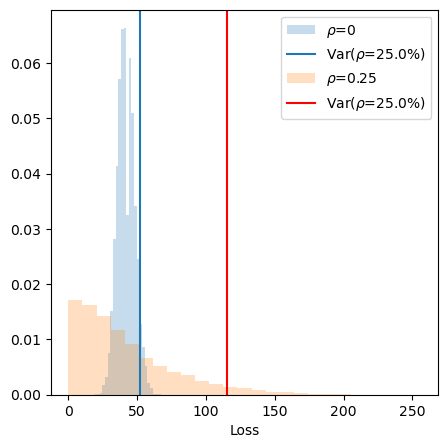

In [38]:
plt.figure(figsize=(5,5))
plt.hist(L0,bins=25,alpha=0.25,density=True,label=rf"$\rho$=0")
plt.axvline(VaR0,label=rf"Var($\rho$={100*rho}%)")
plt.hist(L,bins=25,alpha=0.25,density=True,label=rf"$\rho$={rho}")
plt.axvline(VaR,color="r",label=rf"Var($\rho$={100*rho}%)")
plt.legend()
plt.xlabel("Loss")

### Problem 3.8

Make a plot of 5%-Var vs correlation for in the correlation range $\rho \in(0,1)$

In [39]:
rhos=np.linspace(0,1,101)
VaRs=np.empty(len(rhos))
for idx,rho in enumerate(rhos):
    gen2=np.random.default_rng(seed)
    L=portfolio_losses(T_var,dists,rho,N,gen)
    VaRs[idx]=compute_VaR(alpha_level,L)
    

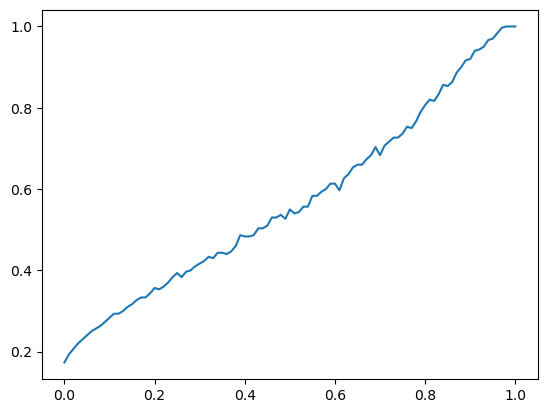

In [40]:
plt.plot(rhos,VaRs/A)


## Bonus Problem 4: Collateralized Debt Obligations (CDOs)

A CDO is a tranched structure backed by a pool of credit sensitive bonds.

Simplifying a lot a  basket of bonds is dividend in tranches:
1. The **equity tranche** will adsorb the first X% of loses 
2. The **mezzanine tranche** will only absorb  losses between X% and Y%
3. The **senior tranche** will only incur losses  if more that Y% of the bonds default.

(Usually there are more  tranches, but, for simplicity, we will keep if fixed at three)

For concreteness less assume the following
1. The maturity of the CDO is $T_\text{cdo}=5$ years
1. There are $A=30$ bonds in the CDO pull.
2. The equity tranche will absorb the first 10 losses.
    $$
        L_{\text{equity}}=\min(D,10)
    $$
    where $D$ is the number of defaults in the pool before maturity $T_\text{cdo}
    =5$
3. The mezzanine will have losses between 10 and 20 defaults:
    $$
        L_{\text{mezzanine}} = \max(\min(D,20),10) -10
    $$
4. The senior tranche will have any losses above 20 defaults:
    $$
        L_{\text{senior}}=\max(D,20)-20
    $$



### Bonus Problem 4.1

1. Implement the tranche loss functions
2. Plot the three tranche losses vs the number of defaults $D$.
3. Verify that 
    $$
        D = L_{\text{equity}}+L_{\text{mezzanine}} + L_{\text{senior}}
    $$



In [41]:
# defaults is a array on $N$ samples of default counts
# the functions return an array of $N$ losses for each tranche
def equity_loss(defaults):
    pass
def mezzanine_loss(defaults):
    pass
def senior_loss(defaults):
    pass


In [42]:
# defaults is a array on $N$ samples of default counts
# the functions return an array of $N$ losses for each tranche
def equity_loss(defaults):
    return np.minimum(defaults,10)


In [43]:
def mezzanine_loss(defaults):
    return np.maximum(np.minimum(defaults,20),10)-10


In [44]:
def senior_loss(defaults):
    return np.maximum(defaults,20)-20


Text(0, 0.5, 'Loss')

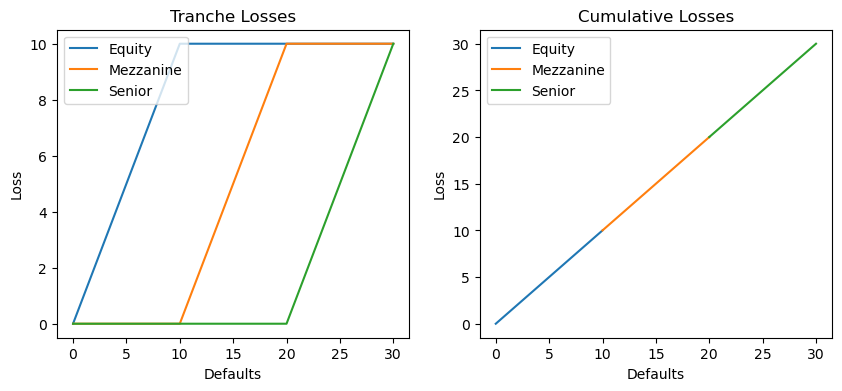

In [45]:
plt.figure(figsize=(10,4))
plt.subplot(121)
D=np.arange(0,31)
plt.title("Tranche Losses")
plt.plot(D,equity_loss(D),label="Equity")
plt.plot(D,mezzanine_loss(D),label="Mezzanine")
plt.plot(D,senior_loss(D),label="Senior")
plt.legend()
plt.xlabel("Defaults")
plt.ylabel("Loss")

plt.subplot(122)
D=np.arange(0,31)
plt.title("Cumulative Losses")
D=np.arange(0,11)
plt.plot(D,equity_loss(D)+mezzanine_loss(D)+senior_loss(D),
           label="Equity")
D=np.arange(10,21)
plt.plot(D,equity_loss(D)+mezzanine_loss(D)+senior_loss(D),
           label="Mezzanine")
D=np.arange(20,31)
plt.plot(D,equity_loss(D)+mezzanine_loss(D)+senior_loss(D),
           label="Senior")
plt.legend()
plt.xlabel("Defaults")
plt.ylabel("Loss")





We assume that the are
1. $A=30$ assets all with the same distribution of default times.
2. For each individual asset the default intensity $\lambda$ is 2%  ( each bond has a 2% probability of default each year)
3. The default times are correlated according to  a Gaussian copula with equal correlation $\rho=50\%$ between each pair of assets.

### Bonus Problem 4.2

1. Use `stats.expon` to define the distribution of default times for each asset
2. Create an array of $A=30$ copies of the default time distribution.
2. Define a Gaussian copula with equal correlation $\rho=50\%$ for all asset pairs.

[HINT] In the `stats.expon` distribution the `scale` parameter is the inverse of the intensity $\lambda$. 


In [46]:

A=30
lambda_=1/0.02

dist=stats.expon(scale=lambda_)
dists=[dist]*A
rho=0.5
corr=(1-rho)*np.identity(A)+rho*np.ones((A,A))
corr.shape
copula=GaussianCopula(corr)


### Bonus Problem 4.3

1. Generate $N=10,000$ samples of the default times of the  $A=30$ assets in the CDO pool using the distribution and copula defined in Bonus Problem 3.2 
2. What the is them and standard deviations of the default times? Does this make sense given that each bond has a 2% chance of defaulting each year?
3. Plot the distribution of default times for the first asset in the pool.
4. Make a scatter plot of the default times of the first and second assets in the pool

[HINT] The default time samples of the pool must be a $N\times A = 10,000 \times 30$  array


In [47]:
Ts=generate_distribution(dists,copula,N,gen)
Ts.shape


(10000, 30)

Text(0, 0.5, '$T_2$')

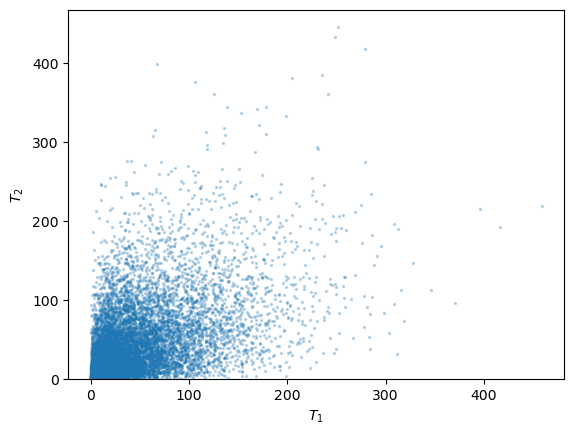

In [48]:
# on a bond will default in 1/2% = 50 years
Ts[:,0].mean(),Ts[:,0].std()
plt.hist(Ts[:,0],bins=25,density=True)
plt.xlabel("years")
plt.scatter(Ts[:,0],Ts[:,1],alpha=0.25,s=2,edgecolors=None)
plt.xlabel("$T_1$")
plt.ylabel("$T_2$")


### Bonus Problem 4.4

Given the default times computed in Bonus Problem 3.3:
1.  compute the number of defaults before the CDO maturity $T_\text{cdo}=5$
on each sample.
2. What is the mean and standard deviation of the number of defaults?

[HINT] you must produce a $N=10,000$ vector of default counts.


In [49]:

T_cdo=5
defaults=(Ts<T_cdo).sum(axis=-1)
np.mean(defaults),np.std(defaults)


(2.8725, 4.566535201878992)

### Bonus Problem 4.5

Compute expected  losses of the three tranches using the Monte Carlo samples and the functions `equity_loss`, `mezzanine_loss` and `senior_loss` that you defined in Bonus Problem 3.1

Show that the sum of the three losses is equal to the mean MC loss you computed in Bonus Problem 4.4
equity_tranche=equity_loss(defaults)


In [50]:
equity_tranche=equity_loss(defaults)
equity_tranche.mean()


2.4433

In [51]:
mezzanine_tranche=mezzanine_loss(defaults)
mezzanine_tranche.mean()

0.3903

In [52]:

senior_tranche=senior_loss(defaults)
senior_tranche.mean()


0.0389

In [53]:
equity_tranche.mean()+mezzanine_tranche.mean()+senior_tranche.mean(),defaults.mean()


(2.8724999999999996, 2.8725)

### Bonus Problem 4.6

Write a function that given the default time distributions, a correlation number, and the CDO expiry
returns the Monte Carlo  estimate (using $N$ samples) of the equity, mezzanine and senior tranche losses.

[HINT] This is just collecting what your have done in problems 3.2 to 3.5 into a single function


In [54]:
def compute_tranches(dists,rho,T_max,N,gen):
    pass


In [55]:
def compute_tranches(dists,rho,T_cdo,N,gen):
    A=len(dists)
    corr=(1-rho)*np.identity(A)+rho*np.ones((A,A))
    copula=GaussianCopula(corr)
    Ts=generate_distribution(dists,copula,N,gen)
    defaults=(Ts<T_cdo).sum(axis=-1)
    equity_tranche=equity_loss(defaults)
    mezzanine_tranche=mezzanine_loss(defaults)
    senior_tranche=senior_loss(defaults)
    return equity_tranche.mean(),mezzanine_tranche.mean(),senior_tranche.mean()



    

### Bonus Problem 4.7

Compute and plot the losses for the three tranches in the range $\rho=[0,1]$, use 1% increments of correlation.


In [56]:

rhos=np.linspace(0,1,101)
equity=np.empty(len(rhos))
mezzanine=np.empty(len(rhos))
senior=np.empty(len(rhos))
for i1,rho in enumerate(rhos):
    gen2=np.random.default_rng(seed)
    e,m,s=compute_tranches(dists,rho,T_cdo,N,gen2)
    equity[i1]=e
    mezzanine[i1]=m
    senior[i1]=s
  

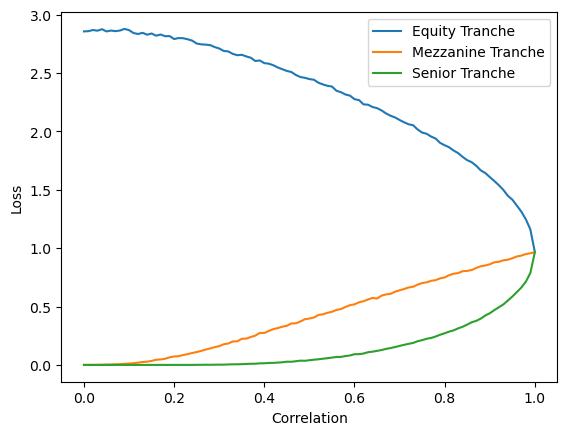

In [57]:
  

plt.plot(rhos,equity,label="Equity Tranche")
plt.plot(rhos,mezzanine,label="Mezzanine Tranche")
plt.plot(rhos,senior,label="Senior Tranche")
plt.xlabel("Correlation")
plt.ylabel("Loss")
plt.legend()